# Part 2: Generative Adversarial Networks: How to Implement a GAN in Python

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/scaleapi/dev-blog/blob/main/exchange-gan-faces/GAN_faces.ipynb)

**Subtitle**: Here’s how to build a GAN for synthesizing face images using the TensorFlow library.

**Summary**: To build a GAN, you have to set up a generator and a discriminator and then train them in an adversarial manner. Here's how.

**Byline**: Mehreen Saeed

In "[Generative Adversarial Networks: What It Is and Why It Matters](https://exchange.scale.com/home/blogs/generative-adversarial-network-what-it-is-and-why-it-matters)," I talked about the basics of GANs and how they are trained. This time I'll show you how to implement a GAN in Python using the TensorFlow library. 

To recap, a GAN is built from two models: a generator and a discriminator. The generator synthesizes artificial data points, and the discriminator distinguishes between fake and real examples. Both models learn in an adversarial manner. During training, the generator learns to create better and better data points until the discriminator cannot tell a real from a fake example. 

Here I'll show you how a GAN can generate synthetic faces by learning the distribution of data from the [Labeled Faces in the Wild (LFW) face-recognition dataset](https://scikit-learn.org/stable/datasets/real_world.html#labeled-faces-in-the-wild-dataset).

## Add the Import Section
The first step is to add the import section.

In [ ]:
# Various classes/modules from tensorflow
from tensorflow.keras import layers, Sequential
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow import GradientTape
from tensorflow.keras.models import clone_model
from tensorflow.data import Dataset
from tensorflow import random, ones_like, zeros_like
from tensorflow.keras.optimizers import Adam
# For plotting
import matplotlib.pyplot as plt
# For math
import numpy as np
# For data
from sklearn.datasets import fetch_lfw_people
# For checking execution time
import time

## Load the Dataset
The scikit-learn library includes the LFW dataset that has grayscale face images of more than 5,000 people. The code below implements the following steps:
1. Load the LFW dataset. Each image is reduced to 40% of its original size.
1. Make the image dimensions a multiple of 2. (I explained why below in the discussion about creating the generator.)
1. Normalize each image so that the grayscale values (0 to 255) are normalized to lie between -1 and +1.
1. Plot the images.
1. Print some statistics.

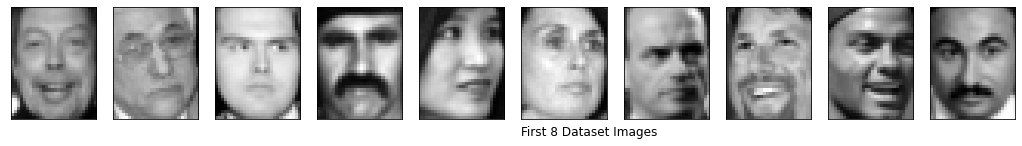

Total  13233 images of size (36, 28, 1)


In [ ]:
BUFFER_SIZE = 50000
BATCH_SIZE = 512

def load_and_display_dataset():
  # Load the dataset or resized images
  lfw_people = fetch_lfw_people(resize=0.3)
  # X holds the images
  X = lfw_people.images
  # Make the image dimensions a multiple of 2
  X = X[:, :int(X.shape[1]/2)*2, :int(X.shape[2]/2)*2]
  # Convert to float
  X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1).astype('float32')
  # Normalize the images to [-1, 1]
  X = (X - 127.9) / 127.9 
  total_cols = 10
  fig, ax = plt.subplots(nrows=1, ncols=total_cols,
                        figsize=(18,4),
                        subplot_kw=dict(xticks=[], yticks=[]))

  for j in range(total_cols):
      ax[j].imshow(lfw_people.images[j, :, :], cmap='gray')
  plt.title('First 8 Dataset Images', y=-0.2, x=-4)    
  plt.show()    
  print('Total ', X.shape[0], 'images', 'of size', X[0].shape)
  # This will convert data to batches and tensorflow format for further processing
  train_dataset = Dataset.from_tensor_slices(X).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
  return X, train_dataset

X, train_dataset = load_and_display_dataset()
# Individual image sizes
im_x, im_y, _ = X[0].shape


## Set Up the Generator

In their "[Generative Adversarial Networks](https://arxiv.org/abs/1406.2661)" paper, Ian Goodfellow and his co-authors describe the discriminator as a general supervised classifier and a generator as an unsupervised model for learning distributions of data. However, they recommend using convolution neural networks (CNNs) when using GANs to synthesize images.

The generator maps randomly sampled data from a distribution to images. This input is also termed the "latent vector" or "random noise." 

The function *setup_generator()*, shown below, creates a generator model using a CNN. The generator is built by connecting successive deconvolution layers for creating progressively larger images. Hence, starting with images half the size of the original, it upsamples them to full-sized images with matching dimensions of the original images. This also explains why the images were preprocessed to even-numbered dimensions. 

![](https://lh5.googleusercontent.com/00dmDI1U41uT5i1fQU3YgWQ_Psw6Pf0zpCcNAAiWWZTTfdKKVeacMbsunVgU0zfJVfBEACBwuu0tP1xMbjxGDCicPkyZxh8dyfm2OYIJGWXpqiChmX2Agjf4KUCaUUleng=w1280)
*Figure 1: The generator model. Source: Mehreen Saeed*

In [ ]:
def setup_generator(image_size, input_len):
    # Small image x and y dimensions
    sm_x = int(image_size[0]/2)
    sm_y = int(image_size[1]/2)
    model = Sequential()
    model.add(layers.Dense(units = sm_x*sm_y*256, input_shape=(input_len, ),
              use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    # Reshape noise to image shape of half dimensions
    model.add(layers.Reshape((sm_x, sm_y, 256)))
    # First deconvolution layer for half image dimensions
    model.add(layers.Conv2DTranspose(128, (3, 3), strides=(1, 1), padding='same', 
                                     use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    # Deconvolution layer for original image_size 
    model.add(layers.Conv2DTranspose(1, (3, 3), strides=(2, 2), padding='same', 
                                     use_bias=False, activation='tanh'))
    model.add(layers.Reshape((image_size[0], image_size[1], 1)))

    return model

latent_vector_len = 128 
generator = setup_generator(X[0].shape, latent_vector_len)
generator.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64512)             8257536   
                                                                 
 batch_normalization (BatchN  (None, 64512)            258048    
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64512)             0         
                                                                 
 reshape (Reshape)           (None, 18, 14, 256)       0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 18, 14, 128)      294912    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 18, 14, 128)      5

## Set Up the Discriminator
We'll set up the discriminator as a CNN using Keras layers. The model is illustrated in the figure below.

![](https://lh5.googleusercontent.com/83NoQSDhAV-dj2DWWg4gn41fPwVftihdA8HdzOqN5ix_Mxq9F6-KqNsGcvEwCnACQBWD6rqpOaP9vHGOiezhSjtMRUWY_1rU6a-Vt4uKdxfhim9_inIbYGBUphhou1SbEw=w1280)
*Figure 2: The discriminator model. Source: Mehreen Saeed*

In [ ]:
def setup_discriminator():     
    model = Sequential()
    # First convolution layer image size
    model.add(layers.Conv2D(32, (3, 3), input_shape=(im_x, im_y, 1), 
                            activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))   
    # Second convolution layer half image size
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    # Flatten the image and pass through dense layer
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(1))
    return model
    
discriminator = setup_discriminator()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 36, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 18, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 18, 14, 64)        18496     
                                                                 
 flatten (Flatten)           (None, 16128)             0         
                                                                 
 dense_1 (Dense)             (None, 512)               8258048   
                                                                 
 dense_2 (Dense)             (None, 1)                 513       
                                                      

## Display the Synthetic Images
We need a function to display synthetic images generated by the generator. The function *show_synth_images()*, displays a few generated images in a single row. Let's run this function and look at the generator's output when no training has been performed. 

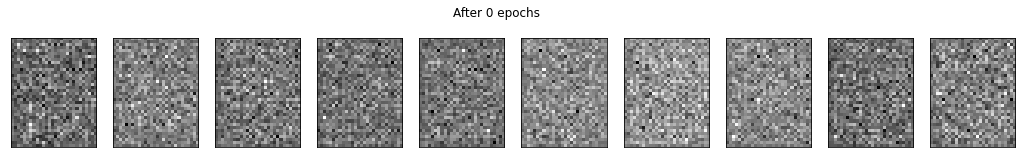

In [ ]:
def show_synth_images(synth_images, epochs, total_to_display=10):
    if total_to_display > synth_images.shape[0]:
        total_to_display = synth_images.shape[0]

    fig, ax = plt.subplots(nrows=1, ncols=total_to_display,
                      figsize=(18,4),
                      subplot_kw=dict(xticks=[], yticks=[]))

    for col in range(total_to_display):
      ax[col].imshow(synth_images[col, :, :, 0] * 127.5 + 127.5,
                     cmap='gray')
    plt.gcf().suptitle('After ' + str(epochs) + ' epochs', y=.8)  
    plt.show()
# Set seed to get the same random numbers every time    
random.set_seed(1234) 
num_examples_to_generate = 10
latent_vector = random.normal([num_examples_to_generate, latent_vector_len]) 
synth_images = generator(latent_vector, training=False)
show_synth_images(synth_images, 0)


## Train the GAN
The function *train_GAN()* carries out the actual training of the network. It implements the following:
1. Sets up the class for computing the binary cross-entropy loss function
1. Sets up the optimizers for both generator and discriminator
1. Trains the generator and discriminator for the number of epochs passed as a parameter

While training the GAN, each image batch is processed in each epoch using the following steps:
1. Generate an input matrix that is randomly sampled from the normal distribution and store it in the variable *noise*. This acts as the random input to the generator. 
1. Get the generator output.
1. Get the discriminator output on both real and synthetic images created by the generator.
1. Compute the loss functions for both generator and discriminator.
1. Compute the gradients corresponding to the loss functions of both the generator and the discriminator.
1. Update the generator and discriminator models based on the gradients.

The *train_GAN()* function returns two arrays, one with the generator loss values and the other with discriminator loss values for each epoch.

You can look at TensorFlow's [Introduction to gradients and automatic differentiation ](https://www.tensorflow.org/guide/autodiff) to understand how gradients are computed and a model is updated during the training phase. 

In [ ]:
def train_GAN(all_images, epochs, noise_len):
    # Set up to compute BinaryCrossentropy
    crossentropy = BinaryCrossentropy(from_logits=True)
    # Set up the optimizers
    generator_optimizer = Adam(1e-4)
    discriminator_optimizer = Adam(1e-4)
    # Hold the history of training
    disc_loss_arr = np.zeros(epochs)
    gen_loss_arr = np.zeros(epochs)
    for e in range(epochs):
        for batch in all_images:
            # Generate the latent input
            noise = random.normal([BATCH_SIZE, noise_len])
            with GradientTape() as generator_tape, GradientTape() as discriminator_tape:
              # Generate images
              synth_images = generator(noise, training=True)
              # Get discriminator decision on synthetic and real images
              output_on_synth = discriminator(synth_images, training=True)
              output_on_real = discriminator(batch, training=True)  
              # Compute loss 
              gen_loss = crossentropy(ones_like(output_on_synth), output_on_synth)
              disc_loss = crossentropy(zeros_like(output_on_synth), output_on_synth) +\
                          crossentropy(ones_like(output_on_real), output_on_real)
            # Get gradients              
            gradients_generator = generator_tape.gradient(gen_loss, generator.trainable_variables)
            gradients_discriminator = discriminator_tape.gradient(disc_loss, discriminator.trainable_variables)

            # Update the models using the gradients
            generator_optimizer.apply_gradients(zip(gradients_generator, generator.trainable_variables))
            discriminator_optimizer.apply_gradients(zip(gradients_discriminator, discriminator.trainable_variables))
            disc_loss_arr[e] = disc_loss_arr[e] + disc_loss.numpy()
            gen_loss_arr[e] = gen_loss_arr[e] + gen_loss.numpy()
        
    return disc_loss_arr, gen_loss_arr
    

## Power Up the GAN
Let's look at the GAN in action. The code below performs training for a fixed number of epochs and displays the corresponding generated images. You can also uncomment two lines of code below if you later want to inspect or use the intermediate states of the generator as it trains and learns to synthesize images.


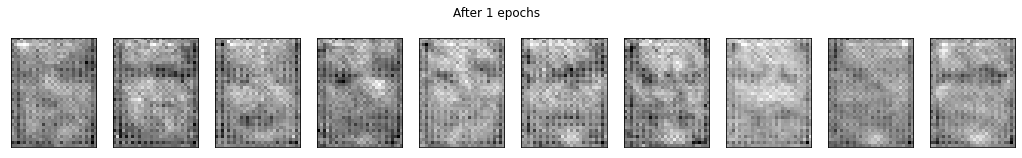

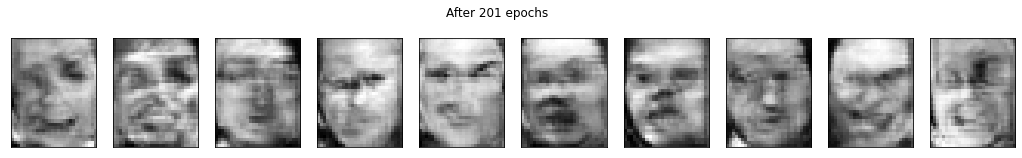

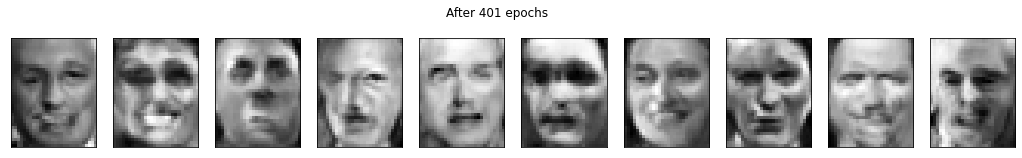

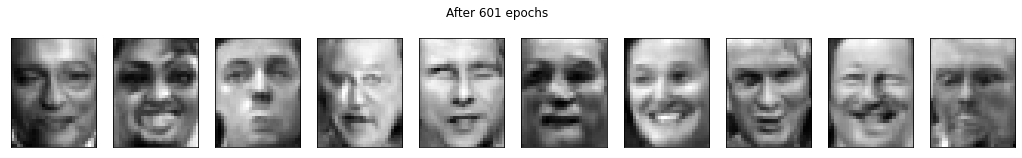

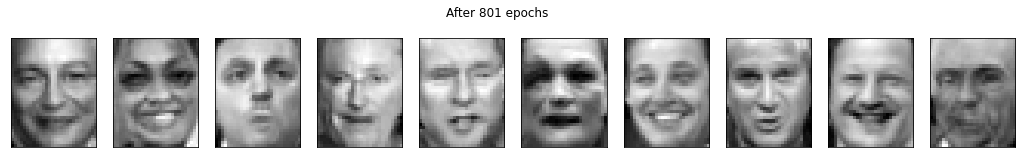

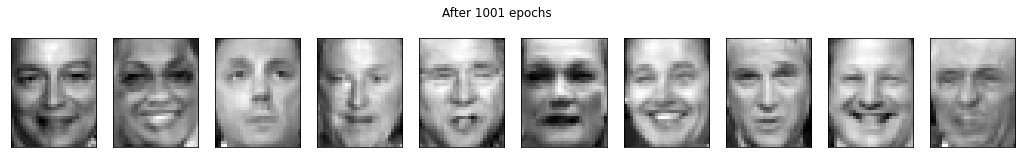

Epochs completed: 1001 Time taken: 3099.9657146930695 secs


In [ ]:
epochs = 1
disc_loss, gen_loss = train_GAN(train_dataset, epochs, latent_vector_len)
synth_images = generator(latent_vector, training=False)
show_synth_images(synth_images, epochs)
start_time = time.time()
# Uncomment to look at the intermediate generator states
# generator_state = []
for i in range(5):   
    dl, gl = train_GAN(train_dataset, 200, latent_vector_len)
    disc_loss = np.append(disc_loss, dl)
    gen_loss = np.append(gen_loss, gl)
    epochs = epochs + 200
    synth_images = generator(latent_vector, training=False)
    show_synth_images(synth_images, epochs)
    # Uncomment to look at intermediate generator states
    # generator_state.append(clone_model(generator))
print('Epochs completed:', epochs, 'Time taken:',
           time.time()-start_time, 'secs')    

After completing training, you can see that we have a pretty good set of artificial images created by the generator. The face features and facial expressions become clearer as the training proceeds.

## View the Learning History
As the last step, let's look at how the loss functions for both the discriminator and generator change with increasing epochs. 

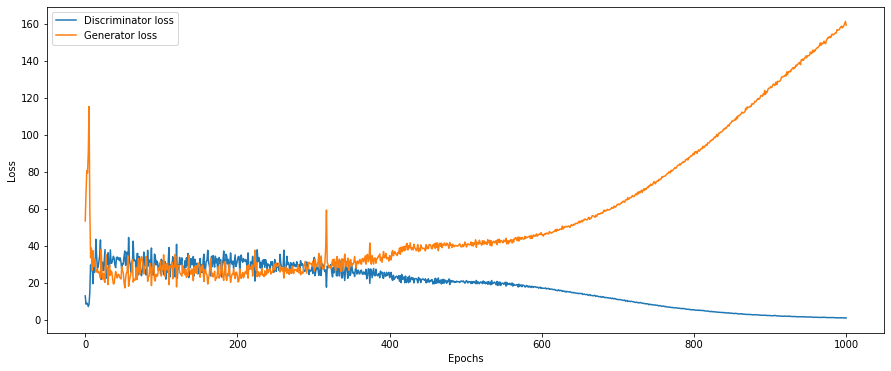

In [ ]:
def plot_training_history(gen_loss, disc_loss):
  fig = plt.figure(figsize=(15,6))
  
  plt.plot(disc_loss)
  plt.plot(gen_loss)
  plt.legend(['Discriminator loss', 'Generator loss'])
  plt.xlabel('Epochs')
  plt.ylabel('Loss')

plot_training_history(gen_loss, disc_loss)  

This is what we expect from how learning proceeds in a GAN. As the discriminator learns to distinguish between real and fake images, and its loss decreases, the generator's loss keeps increasing.

## A Note on Implementation
I am using the Colab Pro+ subscription to run the above example. It took 3,099 seconds (about 52 minutes) to generate the synthetic images. You can run this example at your end locally on your machine. Just leave the training phase running overnight in case you have a slow machine. The training itself needs to be performed only once. Once the generator learns to synthesize images, you can generate as many faces as you like by giving it random samples from the normal distribution. Synthesizing one image is fast. 

## What's Next?
You can build a GAN by putting together a generator and discriminator model and training them together in an adversarial manner. While the GAN we just built is trained to synthesize face images, you can use it to create other types of images: for example, images of animals, natural scenes, different body postures, and more. 

A GAN is useful for generating synthetic images, but you can also use it to generate data from other domains such as financial data, medical records, and synthetic speech. Now that you've got the basics down, consider exploring different GAN variants such as [Cycle GANs](https://openaccess.thecvf.com/content_ICCV_2017/papers/Zhu_Unpaired_Image-To-Image_Translation_ICCV_2017_paper.pdf), [StackGANs](https://arxiv.org/abs/1612.03242), and [conditional GANs](https://arxiv.org/abs/1411.1784). 

Follow this link to download the Jupyter notebook for this tutorial on GANs (***ADD LINK HERE****??).

## Learn More

- [How to Put Generative Models to Work for Synthetic Data](https://exchange.scale.com/public/blogs/how-to-put-generative-models-to-work-for-synthetic-data)
- [Synthetic Data: What It Is and Why It Matters](https://exchange.scale.com/public/blogs/synthetic-data-what-it-is-and-why-it-matters)
- [Generative Adversarial Network: What It Is and Why It Matters](https://exchange.scale.com/home/blogs/generative-adversarial-network-what-it-is-and-why-it-matters) 
